# An SVM classifier with a quantum kernel

In [10]:
from math import pi as PI

import covalent as ct
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import load_wine
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

## Data for our example

We use the 'wine recognition' dataset: 13 properties for 178 wines, each produced by one of three cultivators, 'R', 'G', and 'B'.

**Our goal:** recognize the cultivator based on the wine's *hue* and *colour intensity*.

<img src="http://drive.google.com/uc?export=view&id=1huR0dopjJIHCakkdjimIxEtBLreI2ryP">

## Settings

In [14]:
RANDOM_SEED = 2022
np.random.seed(RANDOM_SEED)

## Quantum kernel sub-task

Our kernel circuit estimates the probability of finding the state $|00\rangle$ upon measurement.

The measurement is characterized by an *operator* (matrix),

$
\begin{align}
\hat{P} = |00\rangle\langle00| = \begin{pmatrix}1\\ 0\\ 0\\ 0\\\end{pmatrix}\begin{pmatrix}1 & 0 & 0 & 0\end{pmatrix} = \begin{pmatrix}1 & 0 & 0 & 0\\ 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0\end{pmatrix}
\end{align}
$

In [15]:
# a projector onto the state |00> -- i.e. the matrix |00><00|
OPERATOR = qml.Hermitian(np.array([[1., 0., 0., 0.],
                                   [0., 0., 0., 0.],
                                   [0., 0., 0., 0.],
                                   [0., 0., 0., 0.]]), wires=range(2))

# random parameters (\theta) for the quantum circuit 
CIRCUIT_PARAMS = np.random.uniform(0., 2 * PI, qml.QAOAEmbedding.shape(1, 2),)


# initialize a quantum device to execute kernel circuit
DEVICE = qml.device("lightning.qubit", wires=2, shots=1000)


@qml.qnode(DEVICE)
def qkernel_circuit(x1, x2):
    """evaluate the quantum kernel circuit on a pair of data points"""
    
    qml.QAOAEmbedding(features=x1,
                      weights=CIRCUIT_PARAMS,
                      wires=range(2))  # encoding x1

    qml.adjoint(qml.QAOAEmbedding)(features=x2,
                                   weights=CIRCUIT_PARAMS,
                                   wires=range(2))  # encoding x2

    # estimate expectation value of `OPERATOR` over 1000 measurement samples
    return qml.expval(OPERATOR)


##### Sanity check

* $\kappa(x_1, x_1) = 1$

* $0 \leq \kappa(x_1, x_2) < 1\quad$ if $\quad x_1 \neq x_2$

* $\kappa(x_1, x_2) \approx \kappa(x_2, x_1)$



In [16]:
x1 = [10.142022, 3.151827]
x2 = [42.1978, 1.1937]

print("quantum kernel circuit with `x1 == x2`\n")
print(qkernel_circuit(x1, x1))
print(qkernel_circuit(x2, x2))
print()
print("quantum kernel circuit on dissimilar inputs (x1, x2) and (x2, x1)\n")
for i in range(5):
    print(qkernel_circuit(x1, x2), "~", qkernel_circuit(x2, x1))

quantum kernel circuit with `x1 == x2`

1.0
1.0

quantum kernel circuit on dissimilar inputs (x1, x2) and (x2, x1)

0.138 ~ 0.158
0.151 ~ 0.163
0.135 ~ 0.149
0.133 ~ 0.148
0.139 ~ 0.149


## Other sub-tasks

In [6]:
@ct.electron
def get_data():
    """load 'wine' data and select desired columns"""
    features, labels = load_wine(return_X_y=True)
    X = features[:, 9:11]  # pick out columns "colour intensity" and "hue"
    y = labels

    scaler = MinMaxScaler((0, 2 * PI))
    scaler.fit(X)

    return scaler.transform(X), y


@ct.electron
def partition_data(X, y):
    """perform a train/test split"""
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        random_state=RANDOM_SEED,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


@ct.electron
def qkernel_matrix(X1, X2):
    """evaluate the quantum kernel circuit over all pairs of data points"""
    return np.array([[qkernel_circuit(x1, x2) for x2 in X2] for x1 in X1])


@ct.electron
def train_qsvm(K_matrix_train, y_train):
    """train the support-vector classifier (SVC)"""
    svc = SVC()
    svc.fit(K_matrix_train, y_train)
    return svc


@ct.electron
def get_metrics(trained_svc, K_matrix_test, y_test):
    """compute classifier metrics"""
    y_pred = trained_svc.predict(K_matrix_test)
    return y_pred, confusion_matrix(y_test, y_pred)

## Workflow

In [7]:
@ct.lattice
def workflow():
    """get the data, partition it, and train SVC on it"""
    
    # load data and partition it
    X, y = get_data()
    X_train, X_test, y_train, y_test = partition_data(X, y)

    # compute train and test matrices
    K_matrix_train = qkernel_matrix(X_train, X_train)
    K_matrix_test = qkernel_matrix(X_test, X_train)
    
    # train the classifier
    trained_svc = train_qsvm(K_matrix_train, y_train)
    
    # get predictions and confusion matrix
    y_pred, M_conf = get_metrics(trained_svc, K_matrix_test, y_test)

    return (X_train, X_test, y_train, y_test), y_pred, M_conf

## Dispatch

In [8]:
# multi-threaded execution using covalent
dispatch_id = ct.dispatch(workflow)()
print(f"dispatch id: {dispatch_id}")
result = ct.get_result(dispatch_id, wait=True)

# unpack result
data, y_pred, M_conf = result.result

navigate to the covalent UI (open [localhost:48008](http://localhost:48008) in your browser) to monitor execution

<img src="http://drive.google.com/uc?export=view&id=1j3-rDHvmb99FxoqyMtypjdEgte0PbBSp" width="1000" />

select the row for the corresponding `dispatch_id` to view the transport graph

<img src="http://drive.google.com/uc?export=view&id=1Dj76FbP1_cnzuMw5ljTFCf23hxygWdIZ" width="1000" />

## Processing and displaying results

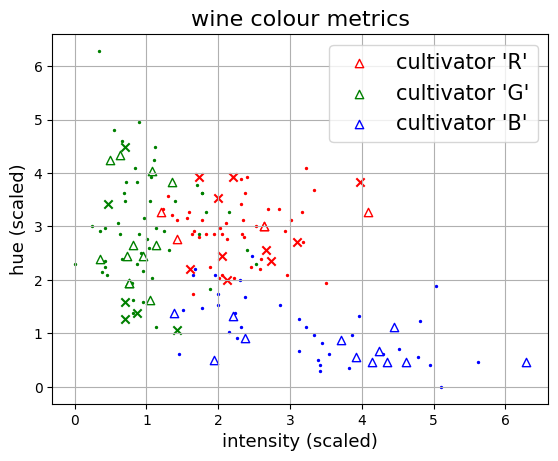

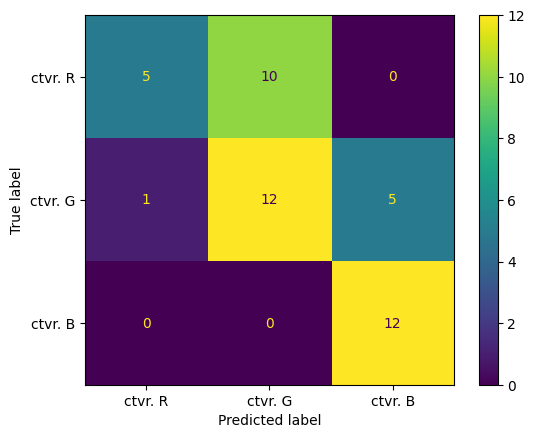

In [12]:

X_train, X_test, y_train, y_test = data

names = ("cultivator 'R'",
         "cultivator 'G'",
         "cultivator 'B'")

colors = ("r", "g", "b")

for i in range(3):
    plt.scatter(X_train[:, 0][y_train == i], X_train[:, 1]
                [y_train == i], c=colors[i], s=2)

idx = np.equal(y_pred, y_test)

for i in range(3):
    # correct
    plt.scatter(X_test[:, 0][np.logical_and(y_test == i, idx)],
                X_test[:, 1][np.logical_and(y_test == i, idx)],
                c='w', marker='^', edgecolors=colors[i], label=names[i])

    # incorrect
    plt.scatter(X_test[:, 0][np.logical_and(y_test == i, ~idx)],
                X_test[:, 1][np.logical_and(y_test == i, ~idx)],
                c=colors[i], marker='x')


plt.title("wine colour metrics", fontsize=16)
plt.xlabel("intensity (scaled)", fontsize=13)
plt.ylabel("hue (scaled)", fontsize=13)
plt.grid()
plt.legend(fontsize=15)
plt.show()

ConfusionMatrixDisplay(M_conf, display_labels=["ctvr. R",
                                               "ctvr. G",
                                               "ctvr. B"]).plot()